# [Hackerearth Predict the Emotion Challenge from audio files](https://www.hackerearth.com/challenges/competitive/ia-for-ai/)

![Problem Statement](https://i.ibb.co/Yf1948g/hackimg.png)


## My Bronze Medal 3rd Place Solution Write Up:

* **Leaderboard Rank** : https://www.hackerearth.com/challenges/competitive/ia-for-ai/leaderboard/

![imgage_leaderboard](https://i.ibb.co/wwWnzvM/hackerearth-emotio-detection-leaderboard.png)

* Firstly, I was occupied in my exams didn't have time. I accidently opened hackerearth found the comeptition been going on for about a month.

* I just joined the competition 3 days before the completion.

* So, Being time constrained, I don't time to experiment a lot. First I thought of using torchaudio models. But ran a first draft through it.

* Then I thought, though torchaudio model could give better given time. To do a fast experiment I have to use CNNs, with spectograms.

* I did audio exploration files conatined both mp3 wav. Since I didn't have attened AMA in beginnig didn't find proper meta regarding audio files. I assumed they were sample at traditional 44100 Hz.

* I used a 5 fold Stratified KFold.

* After exploring the audio lengths. They varied from 0.5s to > 22.0s. I took a distibution of lengths of audio files, took a max lenths of 5 secs for audion spectrograms of size (128,455). If files were less than 5.0s, They were extrpolated of to 5 sec using zeros.

* Converted the train and Test files into MelSpecgrams using librosa audio library. Saved on the drive.

* Choose fastai instead of traditional core pytorch. And changed fastai's codes were needed. 

* Experimented with 6 models architectures. 
    * resnest50
    * efficientnet b0-b4.

* There individual best scores varied from 57 to 59
* I tried making ensemble using different weights to 5 models, they didn't gave better results.
* So for final submission and best score of **61.0835**. I simply took a mode of my best submissions of above 6 models.




In [1]:
!pip install -q gdown
!pip install -q torchaudio

     |████████████████████████████████| 1.9 MB 12.4 MB/s 


In [2]:
import albumentations
import pandas as pd
import gdown
import plotly.express as px
import seaborn as sns
import torch,os
from tqdm.notebook import tqdm
import torch.nn as nn
from torch.nn import functional as F
import torchaudio
import librosa
import numpy as np
import IPython
import matplotlib.pyplot as plt
import audioread
import cv2
from sklearn.model_selection import train_test_split
import torch.nn as nn
import random,os,gc,sys

In [3]:
import warnings
warnings.filterwarnings('ignore')

### Downloading our data and already preprocessed audio files.

In [4]:
url = 'https://drive.google.com/uc?export=download&id=131jmLqPqORC6hdRLaFGb_HEYCtBdPURS' 
output = 'dbb3bd26ead211eb.zip' 
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?export=download&id=131jmLqPqORC6hdRLaFGb_HEYCtBdPURS
To: /content/dbb3bd26ead211eb.zip
435MB [00:05, 76.8MB/s]


'dbb3bd26ead211eb.zip'

In [5]:
url = 'https://drive.google.com/uc?export=download&id=1zbl2e5pqiN7ghLlcVXL2r5nZP_IIWIGk' 
output = 'trainMelspec.zip' 
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?export=download&id=1zbl2e5pqiN7ghLlcVXL2r5nZP_IIWIGk
To: /content/trainMelspec.zip
116MB [00:01, 90.9MB/s]


'trainMelspec.zip'

In [6]:
url = 'https://drive.google.com/uc?export=download&id=1lpq68t-VvnS1k3uNXA5IlbkzhjbL4b4-' 
output = 'testMelspec.zip' 
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?export=download&id=1lpq68t-VvnS1k3uNXA5IlbkzhjbL4b4-
To: /content/testMelspec.zip
50.4MB [00:00, 72.5MB/s]


'testMelspec.zip'

In [7]:
!unzip -qq /content/dbb3bd26ead211eb.zip

In [8]:
df = pd.read_csv('/content/dataset/train.csv')

In [9]:
df['file_path'] = df['filename'].apply(lambda x:f'/content/dataset/TrainAudioFiles/{x}')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5816 entries, 0 to 5815
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   filename   5816 non-null   object
 1   emotion    5816 non-null   object
 2   file_path  5816 non-null   object
dtypes: object(3)
memory usage: 136.4+ KB


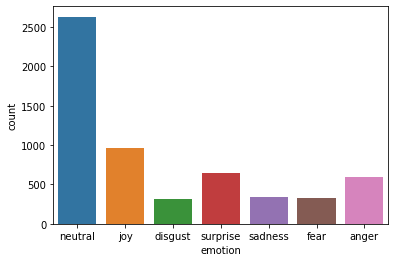

In [11]:
sns.countplot(x=df.emotion);

In [12]:
emotion_map = {'neutral':0, 'joy':1, 'disgust':2, 'surprise':3, 'sadness':4, 'fear':5,'anger':6}

In [13]:
inv_emo = {v: k for k, v in emotion_map.items()};

In [14]:
df['target'] = df['emotion'].map(emotion_map)

In [15]:
df.sample(n=10)

,filename,emotion,file_path,target
761,29353.mp3,neutral,/content/dataset/TrainAudioFiles/29353.mp3,0
3561,28818.mp3,surprise,/content/dataset/TrainAudioFiles/28818.mp3,3
1993,1853.mp3,neutral,/content/dataset/TrainAudioFiles/1853.mp3,0
1453,1306.mp3,sadness,/content/dataset/TrainAudioFiles/1306.mp3,4
2583,24155.mp3,joy,/content/dataset/TrainAudioFiles/24155.mp3,1
3438,7701.mp3,neutral,/content/dataset/TrainAudioFiles/7701.mp3,0
861,24832.mp3,neutral,/content/dataset/TrainAudioFiles/24832.mp3,0
697,15243.mp3,neutral,/content/dataset/TrainAudioFiles/15243.mp3,0
3825,26959.mp3,sadness,/content/dataset/TrainAudioFiles/26959.mp3,4
4136,5097.mp3,neutral,/content/dataset/TrainAudioFiles/5097.mp3,0


In [16]:
tsdf = pd.read_csv('/content/dataset/test.csv')

In [17]:
tsdf['file_path'] = tsdf['filename'].apply(lambda x:f'/content/dataset/TestAudioFiles/{x}')

In [18]:
tsdf.head(3)

,filename,file_path
0,26199.mp3,/content/dataset/TestAudioFiles/26199.mp3
1,692.mp3,/content/dataset/TestAudioFiles/692.mp3
2,16821.mp3,/content/dataset/TestAudioFiles/16821.mp3


In [19]:
!unzip -qq '/content/trainMelspec.zip' -d '/content/TrainMelSpec'

In [20]:
!unzip -qq '/content/testMelspec.zip' -d '/content/TestMelSpec'

In [21]:
!pip uninstall fastai -y

Found existing installation: fastai 1.0.61
Uninstalling fastai-1.0.61:
  Successfully uninstalled fastai-1.0.61


In [22]:
!pip install -Uqq fastai

     |████████████████████████████████| 186 kB 12.5 MB/s 
     |████████████████████████████████| 56 kB 4.1 MB/s 


In [37]:
from fastai.vision.all import *

In [24]:
def get_audio(x):
    try:
        wave = torchaudio.load(x)[0][0]
    except:
        wave,sr = librosa.load(x,sr=44100)
        wave = torch.from_numpy(wave)
    temp_wv = torch.zeros([550634])
    if wave.numel() < 550634:
        temp_wv[:wave.numel()] = wave[:]
    else:
        temp_wv[:] = wave[:550634]
    return temp_wv[::2].unsqueeze(0)

In [25]:
wave = get_audio('/content/dataset/TrainAudioFiles/38543.wav')

In [26]:
def label_func(fname):
    return int(df[df['filename']==fname.name]['target'].values[0])

### StratifiedKFOLD

In [27]:
from sklearn.model_selection import StratifiedKFold

In [28]:
df_comb = df.sample(frac=1.,random_state = 2020)
df_comb['kfold'] = -1
y = df_comb['target'].values
kf = StratifiedKFold(n_splits=5,random_state = 2020,shuffle = True)
for fold ,(trn_,val_ )in enumerate(kf.split(X=df_comb,y=y)):
    df_comb.loc[val_,'kfold'] = fold

In [29]:
df_comb['id'] = df_comb['filename'].apply(lambda x:str(x[:-4])+'.png')

In [30]:
trn_df = df_comb

In [31]:
path = '/content'
FOLD = 1

### Dataloader

In [39]:
def get_data(FOLD,bs=32,sz=128):
    item_tfms = RandomCrop(sz)
    batch_tfms = [Normalize.from_stats(*imagenet_stats)]
    trn_idx,val_idx = trn_df[trn_df.kfold!=FOLD].index, trn_df[trn_df.kfold==FOLD].index
    dls = ImageDataLoaders.from_df(trn_df, path, fn_col = 'id', folder='TrainMelSpec',label_col='target',
                                  bs=bs,y_block=CategoryBlock,item_tfms=None,batch_tfms=batch_tfms,val_idxs=val_idx)
    return dls

In [40]:
dls = get_data(0)

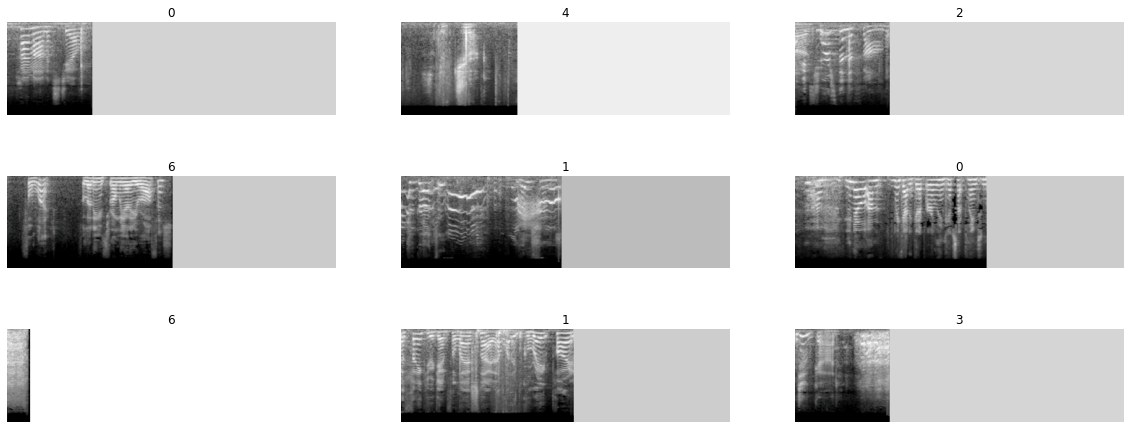

In [41]:
dls.show_batch(figsize=(20,8))

In [42]:
test_data_path = tsdf['filename'].apply(lambda x:f'/content/TestMelSpec/{x[:-4]}.png')

In [43]:
!pip install -q timm

     |████████████████████████████████| 376 kB 10.7 MB/s 


In [44]:
import timm

### Finding Optimal Weights for CrossEntropyLoss

In [45]:
trn_df[trn_df.kfold==0].shape[0] / (7*np.bincount(trn_df[trn_df.kfold==0]['target'].values))

array([0.3062352 , 0.87981859, 2.91729323, 1.52555701, 2.55824176,
       2.10488246, 1.36299766])

In [46]:
7*np.bincount(trn_df[trn_df.kfold==0]['target'].values)/trn_df[trn_df.kfold==0].shape[0]

array([3.26546392, 1.13659794, 0.34278351, 0.65549828, 0.39089347,
       0.47508591, 0.73367698])

### Training models for ensemble

In [47]:
models_list = ['efficientnet_b0','efficientnet_b1','efficientnet_b2','efficientnet_b3','efficientnet_b4','resnest50d']

In [ ]:
test_sc = []
for mdl in models_list:
    print(f'StartifiedKFOLD_{mdl}')
    for F in tqdm(range(5)):
        dls = get_data(F,bs=64)
        wt = torch.FloatTensor([3.26546392, 1.13659794, 0.34278351, 0.65549828, 0.39089347,0.47508591, 0.73367698])
        mymodel = timm.create_model(mdl,pretrained=True,num_classes=dls.c)
        learn = Learner(dls, mymodel,loss_func = LabelSmoothingCrossEntropyFlat(), #cbs=[CutMix()],
                     metrics=[accuracy,F1Score(average='macro')]).to_fp16()
        # Callbacks
        cb1 = SaveModelCallback(monitor='accuracy',fname=f'best_{mdl}_fold_{F}') 
        cb2 = ReduceLROnPlateau(monitor='accuracy', min_delta=0.01, patience=2,factor=0.2)
        learn.fit_one_cycle(20, 1e-3/2,cbs = [cb1,cb2])
        learn.load(f'best_{mdl}_fold_{F}');
        #learn = learn.to_fp32()
        cb3 = SaveModelCallback(monitor='accuracy',fname=f'best_{mdl}_foldB_{F}')
        learn.fit_one_cycle(10, 1e-5/2,cbs = [cb3])
        learn.load(f'best_{mdl}_foldB_{F}');
        tst_dl = learn.dls.test_dl(test_data_path)
        predictions = learn.get_preds(dl = tst_dl)
        test_sc.append(predictions[0].numpy())
        learn,dls,mymodel= None, None, None
        gc.collect()

StartifiedKFOLD_efficientnet_b0


  0%|          | 0/5 [00:00<?, ?it/s]

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,2.321089,2.180791,0.404127,0.283488,01:07
1,1.679345,1.777747,0.446260,0.355233,01:07
2,1.264837,1.785677,0.417885,0.373496,01:07
3,0.940753,1.925820,0.424764,0.410790,01:07


Better model found at epoch 0 with accuracy value: 0.4041272699832916.
Better model found at epoch 1 with accuracy value: 0.44625967741012573.


In [ ]:
test_sc = np.array(test_sc)
test_sc_avg = test_sc.mean(axis=0)

In [ ]:
preds = test_sc_avg.argmax(axis=1);preds.shape

(2492,)

In [ ]:
test_sc_avg.shape

(2492, 7)

In [ ]:
sub = tsdf[['filename']].copy()
sub['emotion'] = preds
sub['emotion'] = sub['emotion'].map(inv_emo)

In [ ]:
sub.to_csv('submission_emotion_detection.csv',index=False)

In [ ]:
sub

,filename,emotion
0,26199.mp3,neutral
1,692.mp3,neutral
2,16821.mp3,neutral
3,1608.mp3,neutral
4,47947.wav,disgust
...,...,...
2487,16692.mp3,neutral
2488,29505.mp3,neutral
2489,5807.mp3,anger
2490,43982.wav,fear
